# Notebook 3: CNN Model

The objective of this project is to create an image classification model by classifying x-rays whether someone has pneumonia or not. The tutorial I followed to run a convolutional neural network to identify whether one has pneumonia or not can be found from [tensorflow.com](https://www.tensorflow.org/tutorials/images/classification)



In [1]:
import glob
import sys
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
# For reproducible results:
from numpy.random import seed
seed(1)
%matplotlib inline

The dataset has the following directory structure:

<pre>
<b>data</b>
|__ <b>train</b>
    |______ <b>PNEUMONIA</b>: [pneumonia_0.jpg, pneumonia_1.jpg, pneumonia_2.jpg ....]
    |______ <b>NORMAL</b>: [normal_0.jpg, normal_1.jpg, normal_2.jpg ...]
|__ <b>test</b>
    |______ <b>PNEUMONIA</b>: [pneumonia_0.jpg, pneumonia_1.jpg, pneumonia_2.jpg ....]
    |______ <b>NORMAL</b>: [normal_0.jpg, normal_1.jpg, normal_2.jpg ...]
</pre>

In [2]:
train_directory = '../data/train/'
test_directory = '../data/test/'

normal_tr = glob.glob('../data/train/NORMAL/*.jpeg')
pneumonia_tr = glob.glob('../data/train/PNEUMONIA/*.jpeg')

normal_test = glob.glob('../data/test/NORMAL/*.jpeg')
pneumonia_test = glob.glob('../data/test/PNEUMONIA/*.jpeg')


print(f"Total training normal images: {len(normal_tr)}")
print(f"Total training pneumonia images: {len(pneumonia_tr)}")
print(f"Total test normal images: {len(normal_test)}")
print(f"Total train normal images: {len(pneumonia_test)}")
print("--")
print("Total training images:", len(glob.glob('../data/train/*/*.jpeg')))
print("Total test images:", len(glob.glob('../data/test/*/*.jpeg')))

Total training normal images: 1341
Total training pneumonia images: 3875
Total test normal images: 242
Total train normal images: 398
--
Total training images: 5216
Total test images: 640


Loading `train_data` and `test_data` which are the images transformed into floating point tensors.

In [3]:
%run '../assets/tensor_data.py'

Found 5216 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


In [4]:
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']
# list of objects
variables = [x for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars]

if 'train_data' in variables and 'test_data' in variables:
    print('train_data and test_data have successfully been imported.')
else:
    print('train_data and test_data have not been imported.')

train_data and test_data have successfully been imported.


## Convolutional Neural Network

#### Building the Model

Keras' Convolutional Neural Network model was implemented to classify whether a patient has pneumonia. There are 9 layers: **convolutional 2D layers**, **max pooling layers**, a single **flatten layer**, and **dense layers**. A CNN is used to capture the spatial distributions in an image by applying the aforementioned filters. 

**Conv2D Layer** is a set of learnable filters. Using the kernel filter, each filter transforms a part of the image to transform parts of the image. Conv2D also has two padding options:
1. Valid Padding - reduces convolved feature dimensionality
2. Same Padding - either increases or leaves the dimensionality alone.

Essentially, the first Conv2D layer captures low-level features such as the images' edges, colors, and gradient orientation. 

Added Conv2D layers allow the model to learn high-level features such as identifying the ribs and lungs in the images.

**Max Pooling Layers** reduce the spatial size of the convolved features and returns the max value from the portion of the image covered by the kernel for three reasons:
1. Decrease the computation power to process the data by dimensionality reduction
2. Extract dominant features by training the model
3. Reduce noise

**Flatten Layer** converts all of the learned features from the previous convolutional layers to a format that can be used by the densely connected neural layer

**Dense Layers** are used to generate the final prediction. It takes in the number of output nodes and has an activation function which we will use the sigmoid activation function. The values for the sigmoid range between 0 and 1 that allows the model to perform a binary classification. 

The first Conv2D is the input layer which takes in the images that have been converted to 224x224x3 floating point tensors.

`ReLu` (recified linear unit) is used as the activation function max(0,x) for the convolutional 2D layers. Essentially, until a threshold is hit, it doesn't activate!

[source](https://missinglink.ai/guides/keras/using-keras-flatten-operation-cnn-models-code-examples/)

In [5]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224 ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

#### Compiling the Model

The compile function has 3 parameters:
1. `optimizer` - controls the learning rate which defines how fast optimal weights for the model are calculated. We will use 'adam'
2. `loss` - defines the loss function which measures how far off the model's predictions are from the actual values. We will use binary crossentropy because we are predicting binary values. 
3. `metrics` - we will use the accuracy score to measure the rate of how well the model predicts correct classifications.

[source](https://missinglink.ai/guides/neural-network-concepts/convolutional-neural-network-build-one-keras-pytorch/)

In [6]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#### Selecting Batch Size and Epochs
Batch size and epochs are hyperparameters for neural networks.

An `epoch` is one forward and backward pass of all the training examples.

A `batch` is the number of training examples in one forward/backward pass. The higher the batch size, the more memory space it occupies. Popular batch sizes are 32, 64, and 128.

The number of `iterations` is the number of batch sizes used to complete one epoch. 

I am going to run 30 epochs with batch sizes of 128.


[source](https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks)

In [7]:
epochs = 30
batch_size = 128

In [8]:
total_train_images = len(glob.glob('../data/train/*/*.jpeg'))
total_test_images = len(glob.glob('../data/test/*/*.jpeg'))

In [9]:
history = model.fit_generator(
    train_data,
    steps_per_epoch = total_train_images // batch_size,
    epochs = epochs,
    validation_data = train_data,
    validation_steps = total_test_images // batch_size,
    verbose = 1
)

Epoch 1/30
40/40 [==============================] - 71s 2s/step - loss: 0.7244 - accuracy: 0.7539 - val_loss: 0.5044 - val_accuracy: 0.7500
Epoch 2/30
40/40 [==============================] - 63s 2s/step - loss: 0.4019 - accuracy: 0.8141 - val_loss: 0.3406 - val_accuracy: 0.8375
Epoch 3/30
40/40 [==============================] - 71s 2s/step - loss: 0.3175 - accuracy: 0.8609 - val_loss: 0.3483 - val_accuracy: 0.8687
Epoch 4/30
40/40 [==============================] - 62s 2s/step - loss: 0.2991 - accuracy: 0.8562 - val_loss: 0.4019 - val_accuracy: 0.8250
Epoch 5/30
40/40 [==============================] - 63s 2s/step - loss: 0.2662 - accuracy: 0.8852 - val_loss: 0.2734 - val_accuracy: 0.8750
Epoch 6/30
40/40 [==============================] - 65s 2s/step - loss: 0.2644 - accuracy: 0.8945 - val_loss: 0.3702 - val_accuracy: 0.8687
Epoch 7/30
40/40 [==============================] - 63s 2s/step - loss: 0.2835 - accuracy: 0.8734 - val_loss: 0.2649 - val_accuracy: 0.9000
Epoch 8/30
40/40 [==

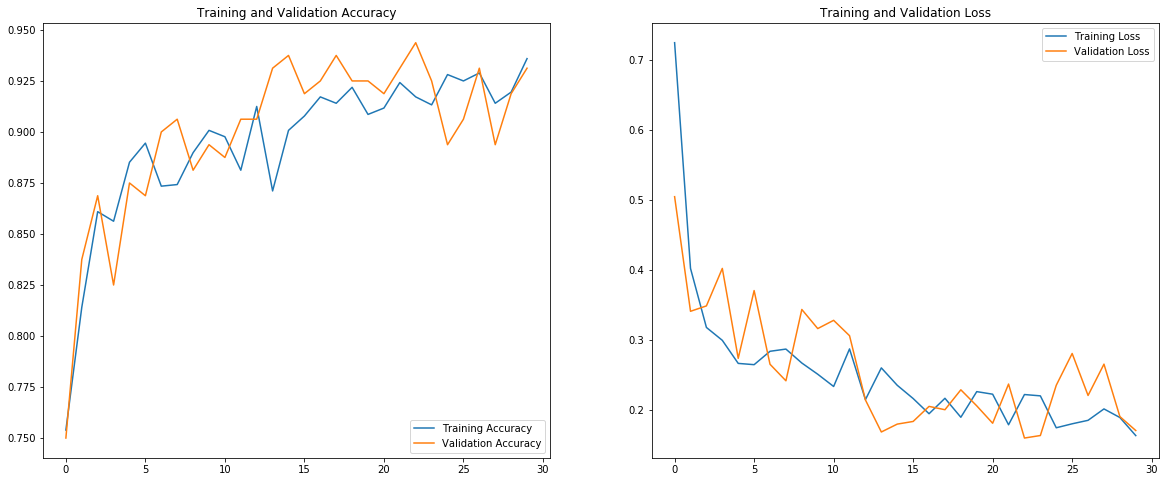

In [10]:
# From https://www.tensorflow.org/tutorials/images/classification

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
y_pred_proba = model.predict(train_data)

In [12]:
y_pred = [1 if x >= 0.5 else 0 for x in list(y_pred_proba[:,0]) ]


In [13]:
list(y_pred_proba[:,0])

[0.99186075,
 0.96196645,
 0.9334264,
 0.9990022,
 0.9998765,
 0.06931281,
 0.9999888,
 0.99999547,
 0.30186063,
 0.99605036,
 0.99577963,
 0.9986447,
 0.96729845,
 0.9969789,
 0.04410371,
 0.98764,
 0.9911362,
 0.9831284,
 0.7731269,
 0.99945134,
 0.99948776,
 0.22921225,
 0.27238446,
 0.9999685,
 0.99869037,
 0.97047395,
 0.9999968,
 0.9999541,
 0.9986932,
 0.9999784,
 0.975047,
 0.078986794,
 0.028438956,
 0.110337555,
 0.9999634,
 0.9999959,
 0.9991996,
 0.9250334,
 0.9999819,
 0.9928789,
 0.99211615,
 0.9994431,
 0.9990854,
 0.9994985,
 0.9983046,
 0.99487484,
 0.99907386,
 0.9835759,
 0.9995355,
 0.014889628,
 0.9989033,
 0.99880946,
 0.10996747,
 0.99981296,
 0.9996419,
 0.99999535,
 0.9929129,
 0.9999852,
 0.4949192,
 0.65976113,
 0.7061532,
 0.9981571,
 0.90951204,
 0.92513937,
 0.9991749,
 0.9889219,
 0.78011394,
 0.99802923,
 0.99982584,
 0.9980633,
 0.47958732,
 0.99983895,
 0.39179587,
 0.999442,
 0.5808886,
 0.9960904,
 0.9999922,
 0.8688002,
 0.05875343,
 0.99999225,
 0.

In [14]:
#y_pred = np.argmax(list(y_pred_proba[:,0]), axis = 0)
#y_pred

In [15]:
y_true = train_data.classes
y_true

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [16]:
y_pred = [1 if x >= 0.5 else 0 for x in list(y_pred_proba[:,0]) ]


In [17]:
cm_def = np.array([['True Negative', 'False Positive'],
                ['False Negative', 'True Positive']])
cm_def = pd.DataFrame(cm_def,columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])


cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, columns = ['pred neg', 'pred pos'], index = ['actual neg','actual pos'])

from IPython.display import display
display(cm_def)
display(cm_df)

,pred neg,pred pos
actual neg,True Negative,False Positive
actual pos,False Negative,True Positive


,pred neg,pred pos
actual neg,286,1055
actual pos,862,3013


In [18]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)


0.6324769938650306